# Denoising Diffusion Probabilistic Models with miniai

Now that we written our barebones training library, lets make some progress towards exploring diffusion model and building Stable Diffusion from scratch.

We will start with building and training the model described in the seminal 2020 paper `Denoising Diffusion Probabilistic Models` (DDPM). For more context, while diffusion models were technically invented back in 2015, diffusion models flew under the randar until this 2020paper since they were complicated and difficult to train. The 2020 paper introducing DDPMs made some crucial assumptions that significantly simplify model training and generation processes, as we will see here. Later versions of diffusion models all build upon the same framework introduced in this paper.

Lets get started and train our own DDPM!

## Imports

We will start with some imports

In [1]:
import random
import fastcore.all as fc
from functools import partial
import matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
import logging

from datasets import load_dataset

import torch
from torch import distributions, nn, tensor, optim
from torch.nn import init
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy

from minai.conv import def_device
from minai.datasets import inplace, show_images, show_image
from minai.learner import MetricsCB, DeviceCB, ProgressCB, DataLoaders, Learner, TrainLearner, SingleBatchCB, MomentumLearner, lr_find, Callback, to_cpu, TrainCB
from minai.activations import Hooks
from minai.init import conv, GeneralRelu, init_weights, ActivationStats, set_seed, BatchTransformCB
from minai.sgd import BatchSchedCB, BaseSchedCB
from minai.resnet import ResBlock

set_seed(42)

/home/studio-lab-user/.conda/envs/fastai/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.9.6) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [2]:
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## Load the dataset

We will load the dataset from HuggingFace Hub:

In [3]:
x, y = 'image', 'label'
name = 'anubhavmaity/notMNIST'
dsd = load_dataset(name)

In [4]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 14979
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3745
    })
})

To make life simpler (mostly with the model architecture), we'll resize the 28x28 images to 32x32

In [5]:
@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32, 32)) for o in b[x]]

Let's set our batch size and create our DataLoaders with this batch size, we can confirm the shapes are correct. Note that while we do get the labels for the dataset, we actually dont care about that for our task of **unconditional** image generation.

In [6]:
set_seed(42)
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([128, 1, 32, 32]), tensor([6, 9, 4, 8, 4, 0, 3, 3, 5, 2]))

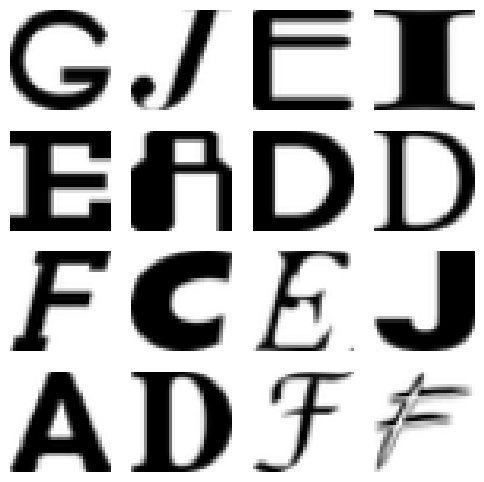

In [7]:
show_images(xb[:16], imsize=1.5)

## Create Model

We will create a U-net. A U-net looks something like this:

The DDPM U-net is a modification of this with some modern tricks like using attention.

We will conver how U-nets are created and how modules like attention work in future lessons. For now, we will import the U-net from diffusers library.

In [8]:
from diffusers import UNet2DModel
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))

## Training - easy with a callback!

DDPM is trained quite simply in a few steps:

1. randomly select some timesteps in an iterative noising process.
2. Add noise corresponding to this timestep to the original image. For increasing timesteps, the variance of the noise increases.
3. Pass in this noisy image and the timestep to our model.
4. Model is trained with an MSE loss between the model output and the amount of noise added to the image.

We will implement this in a callback. The callback will randomly select the timestep and create the noisy image before setting up our input and ground truth tensors for the model forward pass and loss calculation.

After training, we need to sample from this model. This is an iterative denosing process starting from pure noise. We simply keep removing noise predicted by the neural network, but we do it with an expected noise schedule that is reverse of what we saw during training. This is also done in our callback.

In [9]:
betamin, betamax, n_steps = 0.0001, 0.02, 1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1. - beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

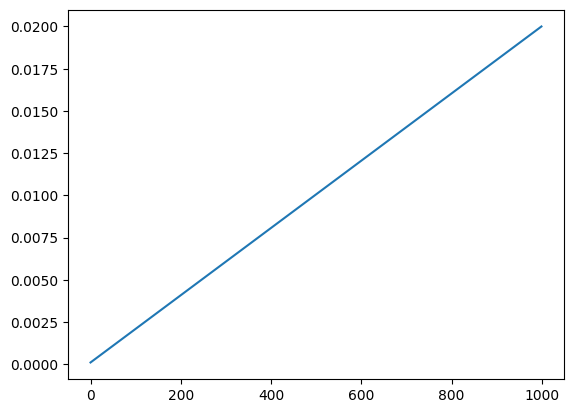

In [10]:
plt.plot(beta)

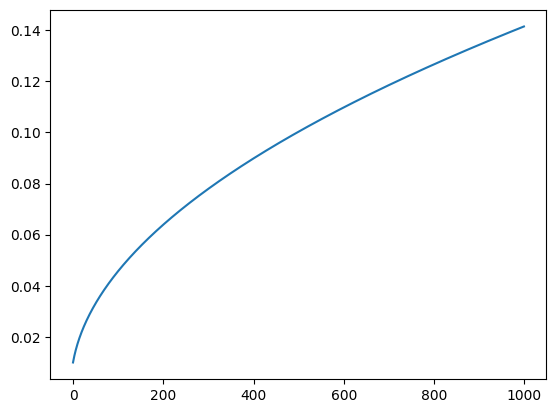

In [11]:
plt.plot(sigma)

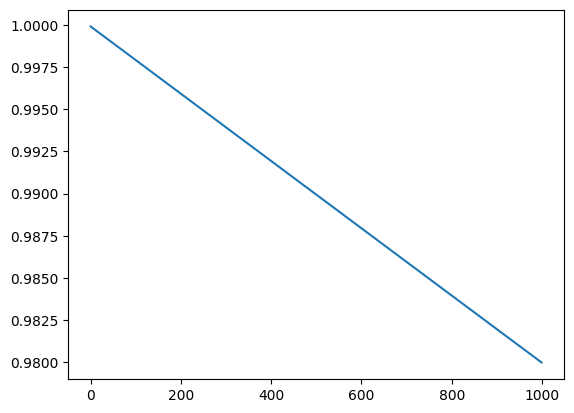

In [12]:
plt.plot(1 - beta)

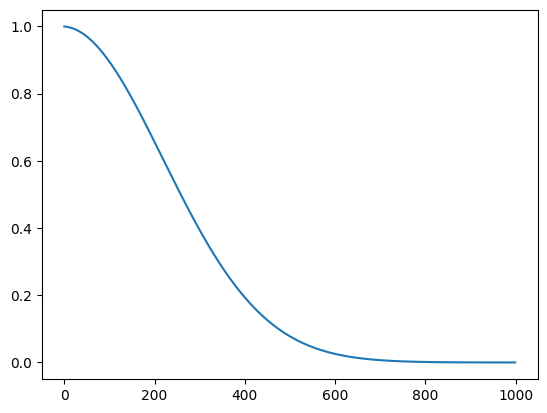

In [13]:
plt.plot(alphabar)

In [10]:
class DDPMCB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        fc.store_attr()
        # variance schedule, linearly increased with timestep
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.alpha = 1. - self.beta 
        self.alphabar = torch.cumprod(self.alpha, dim=0)
        self.sigma = self.beta.sqrt()

    def predict(self, learn): learn.preds = learn.model(*learn.batch[0]).sample
    
    def before_batch(self, learn):
        device = learn.batch[0].device
        epsilon = torch.randn(learn.batch[0].shape, device=device)  # noise, x_T
        x0 = learn.batch[0] # original images, x_0
        self.alphabar = self.alphabar.to(device)
        n = x0.shape[0]
        # select random timesteps
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        alphabar_t = self.alphabar[t].reshape(-1, 1, 1, 1).to(device)
        xt = alphabar_t.sqrt() * x0 + (1-alphabar_t).sqrt() * epsilon #noisify the image
        # input to our model is noisy image and timestep, ground truth is the noise 
        learn.batch = ((xt, t), epsilon)
    
    @torch.no_grad()
    def sample(self, model, sz):
        device = next(model.parameters()).device
        x_t = torch.randn(sz, device=device)
        preds = []
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            alphabar_t1 = self.alphabar[t-1]  if t > 0 else torch.tensor(1)
            betabar_t = 1 - self.alphabar[t]
            betabar_t1 = 1 - alphabar_t1
            noise_pred = learn.model(x_t, t_batch).sample
            x_0_hat = ((x_t - betabar_t.sqrt() * noise_pred)/self.alphabar[t].sqrt()).clamp(-1,1)
            x0_coeff = alphabar_t1.sqrt()*(1-self.alpha[t])/betabar_t
            xt_coeff = self.alpha[t].sqrt() * betabar_t1/betabar_t
            x_t = x_0_hat*x0_coeff + x_t*xt_coeff + self.sigma[t]*z
            preds.append(x_t.cpu())
        return preds

Okay now we are ready to train a model!

Lets create out `Learner`. We will add callbacks and train with MSE loss.

We specify the number of timesteps and the minimum and maximum variance for the DDPM model.

In [11]:
set_seed(64)
lr = 2.2e-3
epochs = 5
tmax = epochs * len(dls.train) 
sched = partial(lr_scheduler.OneCycleLR, max_lr = lr, total_steps=tmax)
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)

Now lets run the fit function

loss,epoch,train
0.160,0,True
0.052,0,False
0.038,1,True
0.039,1,False
0.029,2,True
0.027,2,False
0.024,3,True
0.023,3,False
0.022,4,True
0.022,4,False


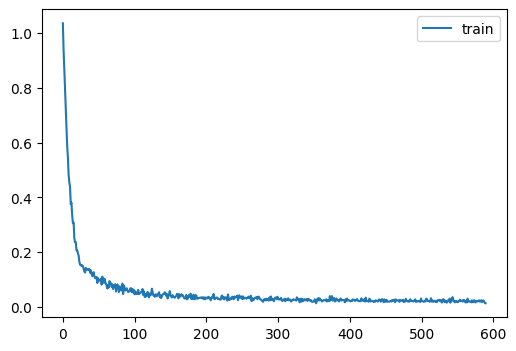

In [26]:
learn.fit(epochs)

In [13]:
mdl_path = fc.Path('models')
mdl_path.mkdir(exist_ok=True)

In [28]:
torch.save(learn.model, mdl_path/'fashion_ddpm.pkl')

In [29]:
learn.model = torch.load(mdl_path/'fashion_ddpm.pkl')

## Further Training

In [37]:
set_seed(64)
lr = 1e-5
epochs = 5
tmax = epochs * len(dls.train) 
sched = partial(lr_scheduler.OneCycleLR, max_lr = lr, total_steps=tmax)
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(learn.model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)

loss,epoch,train
0.017,0,True
0.018,0,False
0.017,1,True
0.017,1,False
0.017,2,True
0.017,2,False
0.016,3,True
0.017,3,False
0.016,4,True
0.017,4,False


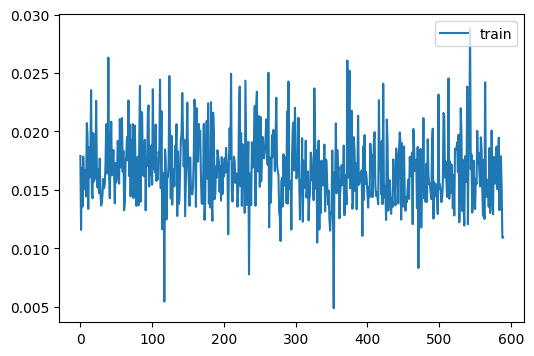

In [38]:
learn.fit(epochs)

In [41]:
torch.save(learn.model, mdl_path/'fashion_ddpm_2.pkl')

## Inference

Now that we have trained our model, lets generate some images with our model:

In [16]:
learn.model = torch.load(mdl_path/'fashion_ddpm_2.pkl', map_location=torch.device('cpu'))

In [17]:
set_seed(42)
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))
len(samples)

1000

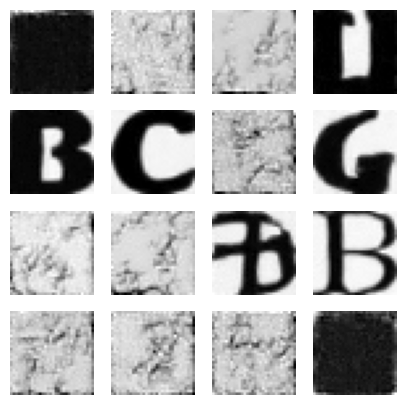

In [18]:
show_images(samples[-1], figsize=(5, 5))

Let's visualize the sampling process

In [19]:
%matplotlib auto
import matplotlib.animation as animation
from IPython.display import display, HTML

fig, ax = plt.subplots(figsize=(3,3))
def _show(i): return show_image(-samples[i][11], ax=ax, animated=True).get_images()
r = fc.L.range(800, 990, 5) + fc.L.range(990, 1000) + [999]*10
ims = r.map(_show)

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=3000)
display(HTML(animate.to_html5_video()))

Using matplotlib backend: <object object at 0x7f9b7814e3b0>


Note that I only take the steps between 800 and 1000 since most of the previous steps are actually quite noisy. This is a limitation of the noise schedule used for small images, and papers like improved ddpm suggest other noise scheduler for this purpose (Some potential homework: try out the noise schedule from improved DDPM and see if it helps)